# Getting familiar with the electrophysiology (Ephys) pipeline

In this notebook, we will take a tour of the Moser group electrophysiolgoy (ephys) pipeline, taking a close look at how each table is defined and relate to each other to represent various experimental information.

But before we begin, let's import a couple essential packages, in particular importing DataJoint (`datajoint`) package, and establish connection to the Moser lab database where the entire pipeline resides.

In [6]:
import datajoint as dj

If you have followed all the setups for Python environment, DataJoint and the Ephys pipeline as described in [Zero to DataJoint Wiki page](https://github.com/kavli-ntnu/dj-elphys/wiki/Zero-to-datajoint), you should be able to just run the next line, importing pipeline definitions as found in the `ephys` package.

In [12]:
from ephys import reference, acquisition, tracking, behavior, ephys
animal = dj.create_virtual_module('mlims', dj.config['custom'].get('mlims.database', 'prod_mlims_data'))

If you experienced any issue in importing the pipeline, please refer to the [Wiki page and guide](https://github.com/kavli-ntnu/dj-elphys/wiki/Zero-to-datajoint) again or seek help from administrators.

The entire pipeline is quite elaborate and contains many parts, grouping related tables together to facilitate navigation and understanding. Rather than looking at them all at once, we will now take a look at each of these groups of tables or **schemas**, one at a time.

## Animal information

Just like any experiment cannot occur without the animal, the entire pipeline also beging with capturing information about the animal. Naturally, information pertaining to the animal can be found under the `animal` schema.

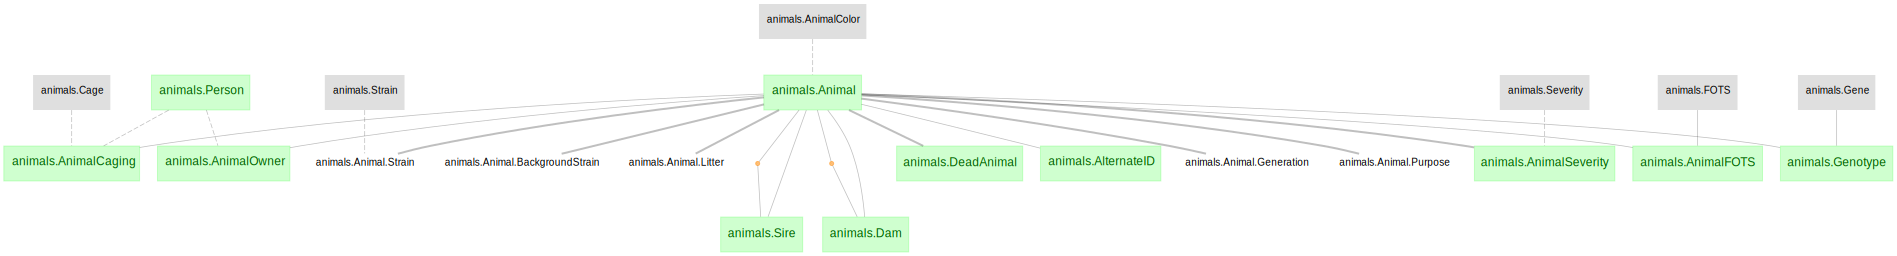

In [15]:
dj.Diagram(animal)

Among other things, the `animal.Animal` table contains listing of all animals in the lab, and as we will see, serve as the starting point for the entire ephys pipeline.

In [16]:
animals.Animal()

animal_id,datasource_id,animal_species,animal_name,animal_sex,animal_dob,color
0000da5d6810d149,0,mouse,85106,F,2018-10-07,None
0000df481fc1421d,0,rat,20399,F,2014-08-06,None
00016d089675e2f2,0,mouse,55885,M,2016-02-12,None
0003a07550faa59b,0,mouse,78224,F,2017-11-30,None
0005070177484ee2,0,rat,20259,M,2014-07-21,None
0005baadae264d7b,0,rat,24790,F,2018-04-12,None
00062843f7d3ffce,0,mouse,55391,F,None,None
00062e8c65bb14f3,0,mouse,52756,M,2015-02-27,None
0006d0993fd101e8,0,mouse,78886,F,2017-12-25,None
00080a60ab6366cd,0,mouse,83976,F,2018-08-01,None


In [7]:
dj.config['database.host'] = 'kavlidatajoint02.it.ntnu.no'

In [8]:
dj.config['custom'] = {'mlims.database': 'prod_mlims_data'}

In [5]:
mlims = dj.create_virtual_module('mlims', dj.config['custom'].get('mlims.database', 'prod_mlims_data'))

Each animal is captured by a unique `animal_id` and `datasource_id`. `datasource_id=0` indicates that these are animals found in MLIMS colony management system.

In [9]:
mlims.Animal()

animal_id,datasource_id,animal_species,animal_name,animal_sex,animal_dob,color
0000da5d6810d149,0,mouse,85106,F,2018-10-07,None
0000df481fc1421d,0,rat,20399,F,2014-08-06,None
00016d089675e2f2,0,mouse,55885,M,2016-02-12,None
0003a07550faa59b,0,mouse,78224,F,2017-11-30,None
0005070177484ee2,0,rat,20259,M,2014-07-21,None
0005baadae264d7b,0,rat,24790,F,2018-04-12,None
00062843f7d3ffce,0,mouse,55391,F,None,None
00062e8c65bb14f3,0,mouse,52756,M,2015-02-27,None
0006d0993fd101e8,0,mouse,78886,F,2017-12-25,None
00080a60ab6366cd,0,mouse,83976,F,2018-08-01,None


In DataJoint, you can probe into or **query** these tables to get a specific subset of data that you may be interested in. The most common type of query is **restriction**, where you'll subselect entries based on specific criteria.

#### Question: Find only rats

In [11]:
mlims.Animal & 'animal_species = "rat"'

animal_id,datasource_id,animal_species,animal_name,animal_sex,animal_dob,color
0000df481fc1421d,0,rat,20399,F,2014-08-06,None
0005070177484ee2,0,rat,20259,M,2014-07-21,None
0005baadae264d7b,0,rat,24790,F,2018-04-12,None
00157eb065da5a2e,0,rat,20461,F,2014-08-27,None
0019025c22abd502,0,rat,20858,F,2014-12-30,None
002bd5b22e5d7d6c,0,rat,21039,F,2015-02-25,None
00342c6d86e97d43,0,rat,25558,F,2019-03-09,None
0057b5e746099ace,0,rat,22414,F,2016-03-04,None
00592804fdd6aec0,0,rat,25624,M,2019-03-26,None
00686ec8eaccdf15,0,rat,20135,M,2014-05-08,None


# Experimental Session

In order to understand how the entire electrophysiology (or `ephys` for short) pipeline is organized, it is essential to first identify some important components of an experimental session.

The following figure demonstrates the structure of an electrophysiology experiment

<img src="../images/Ephys_Session_Structure.png" alt="drawing" width="700"/>

In one ***Session***, there can be:
+ multiple trackings (in time)
+ multiple recordings (in time)
    + one recording per probe
+ multiple probes (different insertion sites)
+ multiple tasks

### Probe and Probe Insertion

### Following the above experiment organization, the diagram below shows the design of the session related part of the ephys pipeline

![session overview](../images/session_overview_erd.png)

An experiment ***Session*** can be uniquely identified by knowing the **animal** and **the exact date time** of the experiment session. This is reflected in the definition of the `Session` table.

In [28]:
acquisition.Session.describe();

-> mlims.Animal
session_time         : datetime                     # start time of this session
---
session_note=null    : longblob                     



Additionally, each session can contain `session_note` where you can place arbitrary notes to describe the session.

In [29]:
acquisition.Session()

animal_id,datasource_id,session_time start time of this session,session_note
00342c6d86e97d43,0,2019-07-04 20:35:12,=BLOB=
40bfa03a7a7018cc,0,2019-09-17 19:43:06,=BLOB=
61fd2ac184c13c73,0,2017-10-02 15:54:25,=BLOB=
61fd2ac184c13c73,0,2018-01-02 11:20:23,=BLOB=
6a61369265b193e8,0,2017-09-08 14:58:22,=BLOB=
6a61369265b193e8,0,2017-10-04 11:15:32,=BLOB=
6a61369265b193e8,0,2018-01-08 13:19:31,=BLOB=
724240a0a756020f,0,2018-04-24 10:25:23,=BLOB=
96129eb1563c0b0d,0,2018-06-21 12:59:28,=BLOB=
bbd19fe400fac5a6,0,2019-09-10 15:34:57,=BLOB=


## Probes and probe insertions

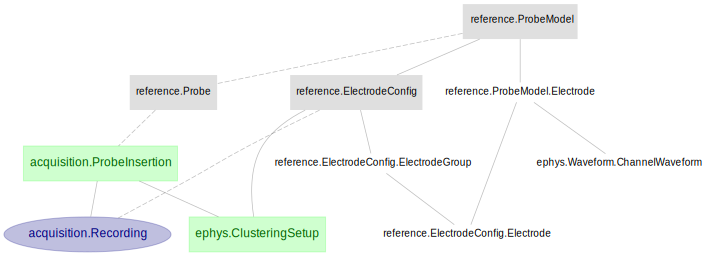

In [34]:
dj.ERD(reference.ProbeModel) + 2

In [33]:
reference.ProbeModel()

"probe_model nick name, or other user-friendly model name of this probe",probe_type
neuropixels_1.0,neuropixels
4-tetrode-array,tetrode_array
8-tetrode-array,tetrode_array


In [32]:
reference.Probe().describe()

# represent a physical probe
probe                : varchar(32)                  # unique identifier of this probe (e.g. serial number)
---
-> reference.ProbeModel



'# represent a physical probe\nprobe                : varchar(32)                  # unique identifier of this probe (e.g. serial number)\n---\n-> reference.ProbeModel\n'

In [30]:
acquisition.ProbeInsertion.describe()

-> mlims.Animal
insertion_time       : datetime                     # When this probe was inserted
---
-> reference.Probe
insertion_note=""    : varchar(1000)                # some notes



'-> mlims.Animal\ninsertion_time       : datetime                     # When this probe was inserted\n---\n-> reference.Probe\ninsertion_note=""    : varchar(1000)                # some notes\n'

In [14]:
acquisition.ProbeInsertion()

animal_id,datasource_id,insertion_time When this probe was inserted,probe unique identifier of this probe (e.g. serial number),insertion_note some notes
00342c6d86e97d43,0,2019-07-03 12:00:00,neuropixel_25558,
40bfa03a7a7018cc,0,2019-09-11 14:08:45,Neuropixel_1,Roger 1
40bfa03a7a7018cc,0,2019-09-11 14:09:22,Neuropixel_2,Roger 2
575882867c176190,0,2019-04-04 00:00:00,microdrive_86866,
61fd2ac184c13c73,0,2016-09-20 15:20:04,tetrode_74956,
61fd2ac184c13c73,0,2017-10-02 00:00:00,tetrode_74956,
6a61369265b193e8,0,2017-09-08 00:00:00,tetrode_74472,
6a61369265b193e8,0,2017-10-04 00:00:00,tetrode_74472,
724240a0a756020f,0,2018-03-15 12:00:00,microdrive_24321_1,
724240a0a756020f,0,2018-03-15 12:10:00,microdrive_24321_2,


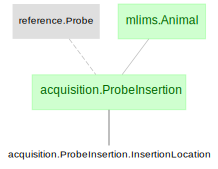

In [20]:
dj.ERD(acquisition.ProbeInsertion) - 1 + acquisition.ProbeInsertion.InsertionLocation

In [23]:
acquisition.ProbeInsertion.InsertionLocation()

animal_id,datasource_id,insertion_time When this probe was inserted,brain_area,hemisphere,skull_reference,ml_location (um) relative to the skull-reference,ap_location (um) relative to the skull-reference,dv_location (um) relative to the surface of the dura at the implant location,ml_angle (degree),ap_angle (degree)
00342c6d86e97d43,0,2019-07-03 12:00:00,MEC - Layer 2,right,lambda,4600.0,100.0,5000.0,0.0,30.0
40bfa03a7a7018cc,0,2019-09-11 14:08:45,MEC - Layer 2,left,lambda,4200.0,0.05,6000.0,25.0,0.0
40bfa03a7a7018cc,0,2019-09-11 14:09:22,MEC - Layer 2,right,lambda,4200.0,0.05,6000.0,25.0,0.0
575882867c176190,0,2019-04-04 00:00:00,MEC - Layer 2,right,lambda,0.0,100.0,1000.0,0.0,0.0
61fd2ac184c13c73,0,2016-09-20 15:20:04,unknown,right,bregma,nan,nan,nan,nan,nan
61fd2ac184c13c73,0,2017-10-02 00:00:00,unknown,left,bregma,nan,nan,nan,nan,nan
6a61369265b193e8,0,2017-09-08 00:00:00,unknown,left,bregma,nan,nan,nan,nan,nan
6a61369265b193e8,0,2017-10-04 00:00:00,unknown,left,bregma,nan,nan,nan,nan,nan
724240a0a756020f,0,2018-03-15 12:00:00,MEC - Layer 2,left,lambda,4600.0,100.0,1900.0,0.0,28.0
724240a0a756020f,0,2018-03-15 12:10:00,MEC - Layer 2,right,lambda,4600.0,100.0,1900.0,0.0,28.0


In each ***Session***, a ***Recording*** corresponds to a single continuous recording from a single probe, and thus is uniquely identifed by the following factors:

* The **session** that the recording belongs to
* A particular instance of an **inserted electrode probe** that the recording was performed on
* Exact start date and time of the recording

Given this, we expect a recording to **depend on** both a `Session` and a `ProbeInsertion`, but also contain an additional primary key attribute/column for the recording start time. We can indeed see this in the definition of the Recording table:

In [25]:
acquisition.Recording.describe();

-> acquisition.Session
-> acquisition.ProbeInsertion
recording_time       : datetime                     # start time of this recording
---
-> reference.RecordingSystem
-> reference.ElectrodeConfig
recording_order      : smallint                     # the ordering of this recording in this session
recording_duration   : float                        # (s) duration of this recording
recording_name=""    : varchar(40)                  # name of this recording (e.g. 27032019laserSess1)



Each ***Recording*** also contains additional information:
+ recording system (e.g. Axona, Neralynx, Neuropixels, Neurologger)
+ electrode configuration (e.g. subset of neuropixels sites, tetrode number)

and depending on the recording system, information needed to perform synchornization to a common time clock spanning the whole session can be found in the `acquisition.Recording.RecordingSync` part table.

![recording](../images/recording_detail_erd.png)

In [12]:
acquisition.Recording()

animal_id,datasource_id,session_time start time of this session,insertion_time When this probe was inserted,recording_time start time of this recording,recording_system,"probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),recording_order the ordering of this recording in this session,recording_duration (s) duration of this recording,recording_name name of this recording (e.g. 27032019laserSess1)
00342c6d86e97d43,0,2019-07-04 20:35:12,2019-07-03 12:00:00,2019-07-04 20:35:12,neuropixels,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,0,2405.48,npx_g0_t0.imec
40bfa03a7a7018cc,0,2019-09-17 19:43:06,2019-09-11 14:08:45,2019-09-17 19:43:06,neuropixels,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,0,7667.25,npx.imec
40bfa03a7a7018cc,0,2019-09-17 19:43:06,2019-09-11 14:09:22,2019-09-17 19:43:06,neuropixels,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,0,7667.45,npx.imec
61fd2ac184c13c73,0,2017-10-02 15:54:25,2017-10-02 00:00:00,2017-10-02 15:54:25,axona,4-tetrode-array,657119cc9e911c2c8a536abce16264f0,0,1958.0,02102017s1
61fd2ac184c13c73,0,2017-10-02 15:54:25,2017-10-02 00:00:00,2017-10-02 16:28:38,axona,4-tetrode-array,657119cc9e911c2c8a536abce16264f0,1,81.0,02102017laserSess1(1mw)
61fd2ac184c13c73,0,2017-10-02 15:54:25,2017-10-02 00:00:00,2017-10-02 16:30:46,axona,4-tetrode-array,657119cc9e911c2c8a536abce16264f0,2,81.0,02102017laserSess1(2mw)
61fd2ac184c13c73,0,2017-10-02 15:54:25,2017-10-02 00:00:00,2017-10-02 16:32:47,axona,4-tetrode-array,657119cc9e911c2c8a536abce16264f0,3,80.0,02102017laserSess1(3mw)
61fd2ac184c13c73,0,2017-10-02 15:54:25,2017-10-02 00:00:00,2017-10-02 16:34:32,axona,4-tetrode-array,657119cc9e911c2c8a536abce16264f0,4,81.0,02102017laserSess1(4mw)
61fd2ac184c13c73,0,2017-10-02 15:54:25,2017-10-02 00:00:00,2017-10-02 16:37:12,axona,4-tetrode-array,657119cc9e911c2c8a536abce16264f0,5,81.0,02102017laserSess1(7mw)
61fd2ac184c13c73,0,2017-10-02 15:54:25,2017-10-02 00:00:00,2017-10-02 16:38:46,axona,4-tetrode-array,657119cc9e911c2c8a536abce16264f0,6,80.0,02102017laserSess1(9mw)


# Organization of Clustering Data



For each ***Recording***, ***UnitSpikeTimes*** can be extracted, per ***Unit*** with spike times from this recording

Clusterings can be performed on:
+ Multiple concatenated sessions (although in most cases, just on one session)
+ Different time window(s) over the selected session(s)
+ Yielding units for this ***clustering***

![](../images/clustering_erd.png)

***ClusteringSetup*** is for users to specify:
+ the ***ClusterSessionGroup*** and ***ClusterTimeWindows***
+ the probe this clustering is performed on - ***ProbeInsertion***
+ the parameters to perform the clustering - ***ClusterParam***
+ the directory to output this clustering results 
+ the electrode configuration information

Note: all of this is taken care of in the ingestion routine (more on that later)

***Clustering*** - a processing step to either trigger the clustering or perform ingestion on performed clustering

***CuratedClustering*** - insert a new curation:
+ the curator
+ the time of curation
+ the directory of the new curation results

In [21]:
ephys.ClusteringSetup.describe();

-> acquisition.ProbeInsertion
-> acquisition.ClusterTimeWindows
-> reference.ClusterParam
-> reference.ElectrodeConfig
-> reference.SyncMethod
---
-> reference.Repository
clustering_output_dir : varchar(128)                 
routine="trigger"    : enum('trigger','import')     
is_synced=1          : tinyint                      # is the clustering output synced to master? - yes if triggered by DataJoint



In [15]:
ephys.CuratedClustering()

animal_id,datasource_id,insertion_time When this probe was inserted,group_name,time_window_id or maybe a hash of all the part windows,cluster_method name of clustering method,"cluster_param_name some unique name, or maybe hash of the dict of the param (ordered)","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime),curator,curation_notes,"repository e.g. 'Local', 'Network'",curation_output_dir
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,valentno,,network,neuropixel/shared_data/Roger/2019-09-17_19-41-14/probe_1/ks2.1_01
40bfa03a7a7018cc,0,2019-09-11 14:09:22,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,valentno,,network,neuropixel/shared_data/Roger/2019-09-17_19-41-14/probe_2/ks2.1_01
724240a0a756020f,0,2018-03-15 12:00:00,det_0d7c5dd06d63c5f14395b914f7f803e7,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,8-tetrode-array,00784804f372476162c7d90e94d8dc3d,presync,2019-08-30 13:14:00,torgeirw,,network,sampledata/deuteron/Torgeir/24321/20180424_01_light/probe_1/ks2.1_01
724240a0a756020f,0,2018-03-15 12:10:00,det_0d7c5dd06d63c5f14395b914f7f803e7,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,8-tetrode-array,00784804f372476162c7d90e94d8dc3d,presync,2019-08-30 13:14:00,torgeirw,,network,sampledata/deuteron/Torgeir/24321/20180424_01_light/probe_2/ks2.1_01
96129eb1563c0b0d,0,2018-06-05 10:51:30,det_67ea7668bb2acfeaa3910a4c0e71fb76,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,8-tetrode-array,00784804f372476162c7d90e94d8dc3d,presync,2019-09-16 11:03:40,valentno,,network,valentno/Data/Ratvissant/20180621/1/Processed/Kilosort
bbd19fe400fac5a6,0,2019-09-16 16:47:17,det_a479a5980e5b604b59c0a1216e251a7f,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-16 11:03:40,valentno,,network,neuropixel/vnormand/Ratounette/2019-09-10_15-32-29/probe_1/ks2.1_01_2265-Inf
bbd19fe400fac5a6,0,2019-09-16 16:47:17,det_a479a5980e5b604b59c0a1216e251a7f,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-16 17:27:44,valentno,test,network,neuropixel/vnormand/Ratounette/2019-09-10_15-32-29/probe_1/ks2.1_01_2265-Inf_new


### A more detailed look to the ***Clustering*** pipeline

![](../images/clustering_detail_erd.png)

### With flexibility comes complexity

<img src="../images/Clustering_ChoiceMatrix.png" alt="drawing" width="450"/>

# Tracking

# Toward the results - Spikes and Tracking

![](../images/spike_track_erd.png)

In [25]:
ephys.UnitSpikeTimes()

animal_id,datasource_id,insertion_time When this probe was inserted,group_name,time_window_id or maybe a hash of all the part windows,cluster_method name of clustering method,"cluster_param_name some unique name, or maybe hash of the dict of the param (ordered)","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime),unit,session_time start time of this session,recording_time start time of this recording,mean_firing_rate mean firing rate,spike_counts how many spikes in this recording of this unit,"unit_spike_times (s) spike times of this unit, relative to the start of the session this recording belongs to"
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,0,2019-09-17 19:43:06,2019-09-17 19:43:06,2.12436,16288,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,1,2019-09-17 19:43:06,2019-09-17 19:43:06,4.88728,37472,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,2,2019-09-17 19:43:06,2019-09-17 19:43:06,3.87792,29733,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,3,2019-09-17 19:43:06,2019-09-17 19:43:06,1.21243,9296,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,4,2019-09-17 19:43:06,2019-09-17 19:43:06,0.283544,2174,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,5,2019-09-17 19:43:06,2019-09-17 19:43:06,0.618866,4745,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,6,2019-09-17 19:43:06,2019-09-17 19:43:06,0.0164335,126,=BLOB=


***UnitSpikeTimes*** and ***Tracking*** data can be matched together - resulting in the ***SpikesTracking***:
> The spike times and tracking data (e.g. position, speed, head angle, etc.) associated with each spike, per unit

And such ***SpikesTracking*** can then be further narrowed down to the task, in ***TaskSpikesTracking***

In [26]:
ephys.SpikesTracking()

animal_id,datasource_id,insertion_time When this probe was inserted,group_name,time_window_id or maybe a hash of all the part windows,cluster_method name of clustering method,"cluster_param_name some unique name, or maybe hash of the dict of the param (ordered)","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime),unit,session_time start time of this session,recording_time start time of this recording,tracking_time start time of this tracking recording,tracking_processing_method,spike_times (s) repeat of SyncedSpikeTimes (for convenient queries),speed (cm/s) tracked speed at each spike times (time with respect to the start of session),x_pos (cm) tracked x-pos at each spike times (time with respect to the start of session),y_pos (cm) tracked y-pos at each spike times (time with respect to the start of session),z_pos (cm) tracked z-pos at each spike times (time with respect to the start of session),head_yaw (degree) tracked head yaw at each spike times (time with respect to the start of session),head_pitch (degree) tracked head pitch at each spike times (time with respect to the start of session),head_roll (degree) tracked head roll at each spike times (time with respect to the start of session),angular_speed (degree/s) tracked head angular speed at each spike times (time with respect to the start of session)
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,3,2019-09-17 19:43:06,2019-09-17 19:43:06,2019-09-17 19:42:39,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,4,2019-09-17 19:43:06,2019-09-17 19:43:06,2019-09-17 19:42:39,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,8,2019-09-17 19:43:06,2019-09-17 19:43:06,2019-09-17 19:42:39,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,9,2019-09-17 19:43:06,2019-09-17 19:43:06,2019-09-17 19:42:39,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,10,2019-09-17 19:43:06,2019-09-17 19:43:06,2019-09-17 19:42:39,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,11,2019-09-17 19:43:06,2019-09-17 19:43:06,2019-09-17 19:42:39,3d_optitrack,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,12,2019-09-17 19:43:06,2019-09-17 19:43:06,2019-

In [27]:
analysis.TaskSpikesTracking()

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamp of task onset with respect to the start of the session,unit unit id,spike_tracking_hash hash of the SpikesTracking primary_key,cell_selection_params_name user-friendly name,spike_times (s) task-related spike times (time with respect to the start of the task),speed (cm/s) task-related speed at each spike times,x_pos (cm) task-related x-pos at each spike times,y_pos (cm) task-related y-pos at each spike times,z_pos (cm) task-related z-pos at each spike times,head_yaw (degree) task-related head yaw (left/right angle) at each spike times,head_pitch (degree) task-related head pitch (up/down) at each spike times,head_roll (degree) task-related head roll (clockwise/anticlockwise) at each spike times,angular_speed (degree/s) task-related head angular speed at each spike times
724240a0a756020f,0,2018-04-24 10:25:23,OpenField,0.00,0,2302a64000a8b5c6a347d228cede17b5,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
724240a0a756020f,0,2018-04-24 10:25:23,OpenField,0.00,1,8f26e58aa05acd610b65e908a907f038,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
724240a0a756020f,0,2018-04-24 10:25:23,OpenField,0.00,4,3b9eefe18801652fd5cf5901fb6a97f8,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
724240a0a756020f,0,2018-04-24 10:25:23,OpenField,0.00,6,209db0c7f1b4ba016ce05d703333d391,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
724240a0a756020f,0,2018-04-24 10:25:23,OpenField,0.00,12,6e812d06eb6de96d9517a94a9735f56f,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
724240a0a756020f,0,2018-04-24 10:25:23,OpenField,0.00,13,e29ae5f77cccb7d0acf5d5d020e110f1,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
724240a0a756020f,0,2018-04-24 10:25:23,OpenField,0.00,14,d42933ad6edea511b74abb397cfa8239,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


# Electrode Configuration